# Text Classification - Router Agent

----

## $\color{blue}{Sections:}$
* Preamble
* Admin - importing libraries
* Load
* Define the graph architecture
* Inference


## $\color{blue}{Preamble:}$


Creation of a graph that will route the data based on the presence of entities. Data points with entities will flow through the GNN, and those without will flow through an MoE model. Both models have been trained with a finetuned embedding model.

A finetuned GPT-4.5o-mini will label the points for entities, and the data will be routed with respect to this output.

After the classification models, both paths converge, high probability predictions are routed to the end, and other are sent to an adjudicator LLM to make a final decision.

The key challenges here are the modification of model calls to return the result of a single data point, and the creation of the graph logic in LangGraph.

## $\color{blue}{Admin:}$

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")
%cd '/content/drive/MyDrive/'


Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
%%capture
pip install dill

In [ ]:
%%capture
pip install langgraph

In [ ]:
%%capture
!pip install -U -q langchain langchain_openai

In [ ]:
import torch
import numpy as np
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## $\color{blue}{Load:}$

In [ ]:
import pandas as pd
path = "class/datasets/"
#df_train = pd.read_pickle(path + "df_train")
df_train = pd.read_pickle(path + "df_train_augmentation_ft")
df_dev = pd.read_pickle(path + "df_dev_augmentation_ft")
df_test = pd.read_pickle(path + "df_test_augmentation_ft")

In [ ]:
df_chapter = pd.read_csv("class/data/chapter_sheet.csv")

In [ ]:
df_chapter.head()

,chapter_idx,book,author,chapter,review
0,0,Ulysses: Telemachia,James Joyce,Telemachus,"In the chapter titled ""Telemachus,"" set on the..."
1,1,Ulysses: Telemachia,James Joyce,Nestor,"In Chapter 2, titled ""Nestor,"" Stephen Dedalus..."
2,2,Ulysses: Telemachia,James Joyce,Proteus,"In the chapter ""Proteus,"" set around 11:00 a.m..."
3,3,Ulysses: Odyssey,James Joyce,Calypso,"In the fourth chapter of Ulysses, titled ""Caly..."
4,4,Ulysses: Odyssey,James Joyce,Lotus Eaters,"In this chapter, Bloom walks to the Westland R..."


In [ ]:
df_dev.shape[0]

746

## $\color{blue}{Graph:}$

#### $\color{red}{Models}$

##### $\color{green}{Get GNN Model:}$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GNNLayer(nn.Module):
    def __init__(self, in_features, out_features, num_relations=1, dropout=0.4):
        super(GNNLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_relations = num_relations
        self.dropout = dropout

        self.T = nn.ParameterList([nn.Parameter(torch.Tensor(in_features, out_features)) for _ in range(num_relations)])
        self.E = nn.ParameterList([nn.Parameter(torch.Tensor(in_features, out_features)) for _ in range(num_relations)])

        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(out_features)

        self.reset_parameters()

    def reset_parameters(self):
        for t in self.T:
            nn.init.xavier_uniform_(t)
        for e in self.E:
            nn.init.xavier_uniform_(e)

    def forward(self, H, A):
        H_out = torch.zeros_like(H)
        for k in range(self.num_relations):
            messages_projection = A[k].T @ H @ self.E[k]
            degrees = A[k].sum(dim=1, keepdim=True)
            degrees[degrees == 0] = 1.0
            messages_projection /= degrees


            self_projection = H @ self.T[k]


            # Include skip connection
            H_out += F.leaky_relu(self_projection + messages_projection) + H

        # Apply batch normalization
        H_out = self.batch_norm(H_out)

        # Apply dropout
        H_out = F.dropout(H_out, p=self.dropout, training=self.training)

        return H_out

class GNNModel(nn.Module):
    def __init__(self, d, h, c, num_relations=1, num_layers=3, dropout=0.4):
        super(GNNModel, self).__init__()
        self.num_layers = num_layers
        self.gnn_layers = nn.ModuleList([GNNLayer(d, d, num_relations, dropout) for _ in range(num_layers)])
        self.fc1 = nn.Linear(d, h)
        self.batch_norm_fc1 = nn.BatchNorm1d(h)
        self.fc2 = nn.Linear(h, c)
        self.dropout = dropout

    def forward(self, H, A):
        for layer in self.gnn_layers:
            H = layer(H, A)

        H = F.relu(self.batch_norm_fc1(self.fc1(H)))
        H = F.dropout(H, p=self.dropout, training=self.training)
        Output = self.fc2(H)
        return Output

    def forward_layer(self, H, A, layer_idx):
        """Forward pass for a specific layer."""
        H = self.gnn_layers[layer_idx](H, A)
        return H


In [ ]:
class GNNModel(nn.Module):
   def __init__(self, d, h, c, num_relations=1, num_layers=2):
      super(GNNModel, self).__init__()
      self.num_layers = num_layers
      self.gnn_layers = nn.ModuleList([GNNLayer(d, d) for _ in range(num_layers)])
      self.fc1 = nn.Linear(d, h)
      self.fc2 = nn.Linear(h, c)

   def forward(self, H, A):
      for layer in self.gnn_layers:
         H = layer(H, A)
      # Classification
      H = F.relu(self.fc1(H))
      Output = self.fc2(H)
      return Output

In [ ]:
import torch.optim as optim

d = 768
h = 400   # hidden dimension of fully connected layer
c = 70   # number of classes
num_relations = 1   # number of relationship types

# Model, Loss, Optimizer
model_gnn = GNNModel(d, h, c, num_relations).to(device)


path_gnn = "class/models/GNN_augmented_ft.pt"
model_gnn.load_state_dict(torch.load(path_gnn))


<All keys matched successfully>

##### $\color{green}{Get GNN Data:}$

In [ ]:
df1 = df_train[['book_idx', 'chapter_idx', 'content', 'direct_ft_augmented_embedding', 'ner_responses']]
df2 = df_dev[['book_idx', 'chapter_idx', 'content', 'direct_ft_augmented_embedding', 'ner_responses']]
df_val = pd.concat([df2,df1])
df_val.reset_index(drop=True, inplace=True)

path = 'class/tensors/adj_{}.pt'
train_entities = torch.load(path.format('train_augmented_entities'))
dev_entities = torch.load(path.format('dev_augmented_entities'))
val_entities = torch.load(path.format('val_augmented_entities'))

##### $\color{green}{Get GNN Sampler:}$

In [ ]:
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy

def sample_neighborhood(A, target, indices, neighbor_max, branch_max, seed=42):
    # Set the random seed for deterministic responses
    if seed is not None:
        np.random.seed(seed)
    indices.append(target)
    np.random.shuffle(A)  # Shuffle the list of adjacency matrices in place
    sampled_indices = set(indices)  # Initialize the set of sampled indices

    for ind in indices:  # Iterate through node in mini-batch
        # print("-----\n ind: ", ind)
        break_to_outer = False
        neighbors = set()

        for adj in A:  # Iterate through all adjacency matrices
            if break_to_outer:
              break

            # Get the indices of all neighbors that idx links to
            disclude = set([ind]) | sampled_indices
            new_neighbors = [neighbor.item() for neighbor in (adj[ind] > 0).nonzero(as_tuple=True)[0] if neighbor.item() not in disclude]
            neighbors.update(new_neighbors)

            if len(neighbors) >= neighbor_max:  # Check if we have too many neighbors
                # Take a random subset using np.random.choice
                neighbors = set(np.random.choice(list(neighbors), neighbor_max, replace=False))


            copy_neighbors = deepcopy(neighbors)
            for idx in copy_neighbors:
                if break_to_outer:
                  break

                neighbors_neighbors = set()
                for adj in A:
                    disclude = set([ind,idx]) | sampled_indices | neighbors
                    new_neighbors_neighbors = [neighbor.item() for neighbor in (adj[idx] > 0).nonzero(as_tuple=True)[0] if neighbor.item() not in disclude]
                    if len(new_neighbors_neighbors) > neighbor_max:
                      new_neighbors_neighbors = set(np.random.choice(list(new_neighbors_neighbors), neighbor_max, replace = False))
                    neighbors_neighbors.update(new_neighbors_neighbors)
                    if len(neighbors) + len(neighbors_neighbors) >= branch_max:
                      neighbors_neighbors = set(np.random.choice(list(neighbors_neighbors), branch_max - len(neighbors), replace=False))
                      neighbors.update(neighbors_neighbors)
                      break_to_outer = True
                      break

                    neighbors.update(neighbors_neighbors)
                    # print("New value of neighbors with new neighbors_neighbors: ", neighbors)

        sampled_indices.update(neighbors)  # Add new neighbors
        # print(f"____\n END OF ind {ind}; sampled indeices is now {sampled_indices}")

    sampled_indices = [int(el) for el in sampled_indices]
    sampled_indices.remove(target)

    return [target] + sampled_indices


##### $\color{green}{GNN-Dataset:}$

In [ ]:
class GNNDataset(Dataset):
  def __init__(self, H, A, labels, meta_indices, neighbor_max=4, branch_max=16, seed=None):
    """Custom dataset with neighborhood sampling

    Args:
      H : torch.tensor
        input embeddings (n x d)

      A : list[torch.tensor]
        list of (n x n)

      labels : torch.LongTensor
        y

      meta_indices : torch.LongTensor
        index of datapoint to filter validation score

      neighbor_max : int
        max neighbors for each node in mini-batch

      batch_max : int
        max size of batch

    """
    # All inits must be tensors
    self.H = H.to(device)
    self.A = [a.to(device) for a in A]
    self.labels = labels.to(device)
    self.meta_indices = meta_indices
    self.neighbor_max = neighbor_max
    self.branch_max = branch_max
    self.seed = seed

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, inds):
    # print('\n####################\n')
    # print('GET ITEM CALLED', 'INDS:', inds)
    # Sample neighborhood
    target = inds[0]
    indices = inds[1:]
    # return the required inds
    sampled_indices = sample_neighborhood(self.A, target, indices, self.neighbor_max, self.branch_max)

    # get the input for the required inds
    H_batch = self.H[sampled_indices]

    # get the adjacency matrix for the required inds
    A_batch = [self.A[k][sampled_indices][:, sampled_indices] for k in range(len(self.A))]

    # get the labels for the required inds
    labels_batch = self.labels[sampled_indices]

    # get meta indices
    index_batch = self.meta_indices[sampled_indices]

    return H_batch, A_batch, labels_batch, index_batch

In [ ]:
H_val = torch.Tensor(np.stack(df_val['direct_ft_augmented_embedding'].to_list()))
labels_val = torch.LongTensor(list(df_val['chapter_idx']))
A_val = []
A_val.append(val_entities)
val_indices = torch.LongTensor(list(range(df_val.shape[0])))
validation_dataset = GNNDataset(H_val, A_val, labels_val, val_indices, neighbor_max=4, branch_max=16, seed=42)

In [ ]:
# sanity check
H_batch, A_batch, labels_batch, index_batch = validation_dataset[[0]]

In [ ]:
# sanity check
labels_batch

tensor([ 0,  6,  8, 13, 15, 16,  8,  8, 15,  0,  8,  1,  1,  0,  0,  1,  0],
       device='cuda:0')

##### $\color{green}{Get Class Model:}$

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DenseBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate):
        super(DenseBlock, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.batch_norm = nn.BatchNorm1d(output_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x

class FeedForwardExpert(nn.Module):
    def __init__(self, dropout_rate):
        super(FeedForwardExpert, self).__init__()

        # Define the dense blocks
        self.block1 = DenseBlock(768, 400, dropout_rate)
        self.block2 = DenseBlock(400, 200, dropout_rate)
        self.final_layer = nn.Linear(200, 70)

        self.initialize_weights()

    def forward(self, x):
        x = self.block1(x)  # Bx768 -> Bx400
        x = self.block2(x)  # Bx400 -> Bx200
        x = self.final_layer(x)  # Bx200 -> Bx70

        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

class MixtureOfExperts(nn.Module):
    def __init__(self, num_experts, dropout_rate=0.1, gate_hidden_size = 128):
      super(MixtureOfExperts, self).__init__()
      self.dropout = dropout_rate
      self.num_experts = num_experts
      self.gate_hidden_size = gate_hidden_size

      # Create a list of feedforward experts
      self.experts = nn.ModuleList([FeedForwardExpert(self.dropout) for _ in range(self.num_experts)])

      # A gating network
      self.gate_fc1 = nn.Linear(768, self.gate_hidden_size)
      self.gate_fc2 = nn.Linear(self.gate_hidden_size, self.num_experts) # Output is num_experts for gating

    def forward(self, x):

      # Calculate gating weights
      gate_hidden = F.relu(self.gate_fc1(x))
      weights = F.softmax(self.gate_fc2(gate_hidden), dim=1).unsqueeze(2) #Shape (batch_size, num_experts, 1)

      # Get outputs from all experts
      outputs = torch.stack([expert(x) for expert in self.experts], dim=2) # Shape: (batch_size, output_size, num_experts)

      # apply weights using a batch mm
      weighted_outputs = torch.bmm(outputs, weights).squeeze(2)

      return weighted_outputs # Shape: (batch_size, output_size)

##### $\color{green}{Get Embedding Model:}$

In [ ]:
import os
from getpass import getpass
from huggingface_hub import login

# Prompt for your Hugging Face token securely
token = userdata.get('HF_TOKEN')

In [ ]:
# Use the token for Hugging Face login
if token:
    print("HuggingFace token has been successfully entered.")
    login(token=token)
else:
    print("Continuing without Hugging Face login")

HuggingFace token has been successfully entered.


##### $\color{green}{Graph with NoEntity Classifier:}$

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-base")
embedding_model = AutoModel.from_pretrained("thenlper/gte-base")
embedding_path = "class/models/direct_ft_augmented_embedding_model.pt"
embedding_model.load_state_dict(torch.load(embedding_path))

classification_model = MixtureOfExperts(3,.15).to(device)
classification_path = "class/models/direct_ft_augmented_soft_moe_model.pt"
classification_model.load_state_dict(torch.load(classification_path))


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

<All keys matched successfully>

#### $\color{red}{State}$

In [ ]:
import torch.nn.functional as F
from torch import Tensor
from langgraph.graph import Graph, START, END
from IPython.display import Image, display
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI


class State:
    # Embedding Model
    embedding_model = embedding_model
    tokenizer = tokenizer

    # Classification Model
    classification_model = classification_model.eval()

    # GNN Model
    gnn_model = model_gnn.eval()  # Set this to your GNN instance T.B.C

    # GPT-4o for adjudication
    llm_4o = ChatOpenAI(model="gpt-4o", temperature=0)

    # Finetuned GPT-4o mini for entity extraction
    llm_ner = ChatOpenAI(model="ft:gpt-4o-mini-2024-07-18:personal::AbTiRIUJ",temperature=0)

    # Data / distance and global probability threshold
    data = validation_dataset
    threshold = 0.95

    def __init__(self, idx: int, text: str, label : int, print_me : bool = False):
        """Updated on instantiation"""
        # basic instantiation
        self.idx = idx
        self.text = text
        self.label = label
        self.print_me = print_me

        """Updated by the Graph """
        # Routing
        self.entities = None # detect_entities (router function)
        self.ner = None # detect_entities for logging only (ner response)

        # Preparation
        self.embedding = None # no_entities / entities_embedding_node
        self.batch = None # entities_batch_node

        # Model Call
        self.output = None # get_gnn_classification / get_classificiation - (instance method)
        self.probabilities = None # probability_node
        self.classes = None # probability_node
        self.model_prediction = None # probability_node
        self.model_correct = None # probability_node

        # Adjudicator Call
        self.adjudicator_prediction = None # Decision Model Node
        self.adjudicator_correct = None # Decision Model Node

    def average_pool(self, last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
        """Helper function to average token embeddings."""
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

    def get_classification_embedding(self, input_text):
        batch_dict = self.tokenizer(input_text, max_length=512, padding=True, truncation=True, return_tensors='pt')
        output = self.embedding_model(**batch_dict)
        self.embedding = self.average_pool(output.last_hidden_state, batch_dict['attention_mask'])
        self.embedding = F.normalize(self.embedding, p=2, dim=1)
        self.embedding = self.embedding.cpu().detach().to(device)


    def get_gnn_embedding(self, input_text):
        """Using classification embedding model at this stage """
        batch_dict = self.tokenizer(input_text, max_length=512, padding=True, truncation=True, return_tensors='pt')
        output = self.embedding_model(**batch_dict)
        self.embedding = self.average_pool(output.last_hidden_state, batch_dict['attention_mask'])
        self.embedding = F.normalize(self.embedding, p=2, dim=1)
        self.embedding = self.embedding.cpu().detach().to(device)


    def get_classification(self):
        """Call classification model and get state.output."""
        with torch.no_grad():
            output = self.classification_model(self.embedding)
            self.output = torch.nn.functional.softmax(output, dim=1)

    def get_gnn_classification(self):
        """Call the GNN model and get state.output."""
        with torch.no_grad():
            H_batch, A_batch, labels_batch, index_batch = self.batch
            H = H_batch.squeeze(0)
            A = [a.squeeze(0) for a in A_batch]
            y = labels_batch.squeeze(0)
            indices = index_batch.squeeze(0)
            output = self.gnn_model(H,A)
            target_output = output[0].unsqueeze(0)
            self.output = torch.nn.functional.softmax(target_output, dim=1)




#### $\color{red}{Prompts}$

##### $\color{green}{Adjudicator:}$

In [ ]:
from pydantic import BaseModel

class Classification(BaseModel):
    value: int

adjudicate_prompt = """
You are part of a text classification pipeline, where we are trying to assign a short of text to a specifice chapter of one of 4 books.
There are in total 70 classes indexed between 0 and 69 inclusive.

A neural network has been used to make classification, but the classification has been deemed unsafe because the probability of the
most likely class is too low.

You will be given the ###Input Text### and the top 3 classifications made by the model. You will also recieve a ###Summary### of
each of the three chapters, and the probability assigned by the model. Your job take into account the text, the chapter summaries,
and the model probabilities,and decide on the best classification. If the summaries don't help then you should choose the chapter with
the highest model probability. But don't be afraid to back yourself and take a risk if it is justified.

The only answer you will provide is an integer between 0 - 69 inclusive (the "reference" of the most likely chapter), you will provide absolutely no other output.

###Input text###
{input_text}

###Summary 1###
Reference: {chapter_idx_1}
Model Probability: {probability_1}
Book: {book_1}
Author: {author_1}
Chapter Title: {chapter_1}
Chapter Summary: {summary_1}

###Summary 2###
Reference: {chapter_idx_2}
Model Probability: {probability_2}
Book: {book_2}
Author: {author_2}
Chapter Title: {chapter_2}
Chapter Summary: {summary_2}

###Summary 3###
Reference: {chapter_idx_3}
Model Probability: {probability_3}
Book: {book_3}
Author: {author_3}
Chapter Title: {chapter_3}
Chapter Summary: {summary_3}
"""


##### $\color{green}{NER:}$

In [ ]:
# change detect entities we don't need structured output

from langchain_core.messages import SystemMessage, HumanMessage

class Ner(BaseModel):
    value: str

ner_prompt = """The task is to label the Location and Person entities in the given ###Text section, Following the format in the ###Examples section.
The output should be identicle to the input with the exception of the Person and Location tags if required.

###Examples
Input: “Is it John of Tuam?”   “Are you sure of that now?” asked Mr Fogarty dubiously. “I thought it was some Italian or American.”
Output: “Is it @@John of Tuam##Person ?”   “Are you sure of that now?” asked @@Mr Fogarty##Person dubiously. “I thought it was some Italian or American.”

Input: sibly there were several others. He personally, being of a sceptical bias, believed and didn’t make the smallest bones about saying so either that man or men in the plural were always hanging around on the waiting list about a lady,
Output: sibly there were several others. He personally, being of a sceptical bias, believed and didn’t make the smallest bones about saying so either that man or men in the plural were always hanging around on the waiting list about a lady,

Input: Now to the historical, for as Madam Mina write not in her stenography, I must, in my cumbrous old fashion, that so each day of us may not go unrecorded. We got to the Borgo Pass just after sunrise yesterday morning.
Output: Now to the historical, for as @@Madam Mina##Person write not in her stenography, I must, in my cumbrous old fashion, that so each day of us may not go unrecorded. We got to the @@Borgo Pass##Location  just after sunrise yesterday morning.

**DON'T LABEL PRONOUNS AS PERSON**

###Text
Input: {input_text}
Output:"""


system_message = SystemMessage(content="You are an excellent linguist.")


#### $\color{red}{LangGraph}$

##### $\color{green}{Decision-Nodes:}$

In [ ]:
from langgraph.graph import Graph, START, END
from IPython.display import Image, display
from typing_extensions import TypedDict

def detect_entities(state: State):
    if state.print_me:
      print(f"Received state in detect_entities: {state}")

    prompt = HumanMessage(content=ner_prompt.format(input_text=state.text))
    structured_llm = state.llm_ner.with_structured_output(Ner)
    response = structured_llm.invoke([system_message, prompt]).value
    state.ner = response
    state.entities = "@@" in response
    if state.entities:
        if state.print_me:
          print('This text has entities.')
        return "EntitiesEmbeddingNode"
    else:
        if state.print_me:
          print('this does not have entities')
        return "NoEntitiesEmbeddingNode"

def check_probability(state: State):
    if state.print_me:
      print("checking_probabilities")
      print(state.probabilities[0])
      print(state.threshold)
    if state.probabilities[0] > state.threshold:
      return END
    else:
      return "AdjudicatorModelNode"


def verify_graph(state: State):
    _, A_batch, labels_batch, inds = state.batch
    A = A_batch[0]
    if int(torch.sum(A[0])) == 1:   # adjacency matrix has only one element
      if state.print_me:
        print("oops no graph, switching to no entity path!")
      return "NoEntitiesClassificationNode"
    else:
      if state.print_me:
        print("datapoint is on the graph, continuing...")
      return "EntitiesGNNNode"

##### $\color{green}{Common-Nodes:}$

In [ ]:
def ner_model_node(state: State):
    if state.print_me:
      print("Starting graph traversal")
    return state

def probability_node(state: State):
    if state.print_me:
      print("Checking the validity of the prediction.")
    probabilities, classes = torch.topk(state.output, k=3, dim=1)
    state.probabilities = probabilities[0]
    state.classes = classes[0]
    _, predicted = torch.max(state.output, 1)
    if state.print_me:
      print(predicted.item())
    state.model_prediction = predicted.item()
    if state.label != None:
        state.model_correct = state.model_prediction == state.label
    if state.print_me:
      print(f'classes: {state.classes}')
      print(f'probabilities: {state.probabilities}')
      print(f'correct: {state.model_correct}')

    return state

def adjudicator_model_node(state : State):
    if state.print_me:
      print("LLM is making a decision.")
    chapter_1 = df_chapter.loc[state.classes[0].item()]
    chapter_2 = df_chapter.loc[state.classes[1].item()]
    chapter_3 = df_chapter.loc[state.classes[2].item()]

    prompt = adjudicate_prompt.format(
        input_text=state.text,

        chapter_idx_1 = chapter_1['chapter_idx'],
        probability_1 = str(round(state.probabilities[0].item(),4)),
        book_1 = chapter_1['book'],
        author_1 = chapter_1['author'],
        chapter_1 = chapter_1['chapter'],
        summary_1 = chapter_1['review'],


        chapter_idx_2 = chapter_2['chapter_idx'],
        probability_2 = str(round(state.probabilities[1].item(),4)),
        book_2 = chapter_2['book'],
        author_2 = chapter_2['author'],
        chapter_2 = chapter_2['chapter'],
        summary_2 = chapter_2['review'],

        chapter_idx_3 = chapter_3['chapter_idx'],
        probability_3 = str(round(state.probabilities[2].item(),4)),
        book_3 = chapter_3['book'],
        author_3 = chapter_3['author'],
        chapter_3 = chapter_3['chapter'],
        summary_3 = chapter_3['review']

    )
    if state.print_me:
      print(prompt)

    structured_llm = state.llm_4o.with_structured_output(Classification)
    state.adjudicator_prediction = structured_llm.invoke(prompt).value
    state.adjudicator_correct = state.adjudicator_prediction == state.label

    if state.print_me:
      print('Adjudicator prediction: ',state.adjudicator_prediction)

    return state



##### $\color{green}{Entity-Nodes:}$

In [ ]:
def entities_embedding_node(state: State):
    if state.print_me:
      print("Embedding the entity state.")
    state.get_gnn_embedding(state.text)
    return state

def entities_batch_node(state: State):
    if state.print_me:
      print("Getting batch and adjacency information.")
    seeds = [state.idx]
    others = np.random.choice(list(range(len(df_val))), 63, replace=False)
    for el in others:
      seeds.append(int(el))
    state.batch = state.data[seeds]
    return state

def entities_gnn_node(state: State):
    if state.print_me:
      print("Calling the GNN.")
    state.get_gnn_classification()
    return state

def no_graph_node(state: State):
    if state.print_me:
      print("Checking that there is a graph.")
    return state

##### $\color{green}{NoEntity-Nodes:}$

In [ ]:
def no_entities_embedding_node(state: State):
    if state.print_me:
      print("Embedding the no entity state.")
    state.get_classification_embedding(state.text)
    return state

def no_entities_classification_node(state: State):
    if state.print_me:
      print("Calling the MoE classifier.")
    state.get_classification()
    return state


##### $\color{green}{Build-Graph:}$

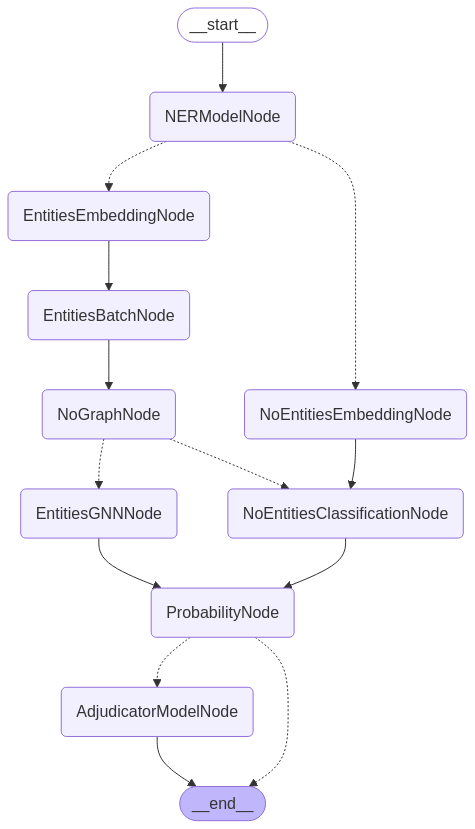

In [ ]:
# Build the graph
builder = Graph()
builder.add_node("NERModelNode", ner_model_node)
builder.add_node("EntitiesEmbeddingNode", entities_embedding_node)
builder.add_node("NoEntitiesEmbeddingNode", no_entities_embedding_node)
builder.add_node("NoEntitiesClassificationNode", no_entities_classification_node)
builder.add_node("ProbabilityNode", probability_node)
builder.add_node("AdjudicatorModelNode", adjudicator_model_node)
builder.add_node ('EntitiesBatchNode', entities_batch_node)
builder.add_node("EntitiesGNNNode", entities_gnn_node)
builder.add_node("NoGraphNode", no_graph_node)


# Define edges

# Entity Decision
builder.add_edge(START, "NERModelNode")
builder.add_conditional_edges(
    "NERModelNode",
    detect_entities,
    {"EntitiesEmbeddingNode": "EntitiesEmbeddingNode", "NoEntitiesEmbeddingNode": "NoEntitiesEmbeddingNode"} #fixes viz problem by specifying the map path
)

# Entities Path
builder.add_edge("EntitiesEmbeddingNode", "EntitiesBatchNode")
builder.add_edge("EntitiesBatchNode", "NoGraphNode")
builder.add_conditional_edges(
    "NoGraphNode",
    verify_graph,
    {"EntitiesGNNNode" : "EntitiesGNNNode", "NoEntitiesClassificationNode" : "NoEntitiesClassificationNode"}
)
builder.add_edge("EntitiesGNNNode", "ProbabilityNode")
builder.add_conditional_edges(
    "ProbabilityNode",
    check_probability,
    {"AdjudicatorModelNode": "AdjudicatorModelNode", END : END}
)

# No Entities Path
builder.add_edge("NoEntitiesEmbeddingNode", "NoEntitiesClassificationNode")
builder.add_edge("NoEntitiesClassificationNode", "ProbabilityNode")

builder.add_edge("AdjudicatorModelNode", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

#### $\color{red}{Sanity-Check}$

In [ ]:
p = 0
print(p)
print(df_val.loc[p].content)
print(df_val.loc[p].chapter_idx)
print(df_val.loc[p].ner_responses)

0
Stately, plump Buck Mulligan came from the stairhead, bearing a bowl of lather on which a mirror and a razor lay crossed. A yellow dressinggown, ungirdled, was sustained gently behind him on the mild morning air. He held the bowl aloft and intoned:   —Introibo ad altare Dei.
0
Stately, plump @@Buck Mulligan##Person came from the stairhead, bearing a bowl of lather on which a mirror and a razor lay crossed. A yellow dressinggown, ungirdled, was sustained gently behind him on the mild morning air. He held the bowl aloft and intoned:   —Introibo ad altare Dei.


In [ ]:
p_content = df_val.loc[p].content
p_chapter_idx = df_val.loc[p].chapter_idx
t = State(idx=p, text=p_content, label=p_chapter_idx,print_me=True)
print(f"\nInvoking graph with label: {t.label}, and text: {t.text}")
s = graph.invoke(t)  # Ensure graph.invoke is correctly passing the state


Invoking graph with label: 0, and text: Stately, plump Buck Mulligan came from the stairhead, bearing a bowl of lather on which a mirror and a razor lay crossed. A yellow dressinggown, ungirdled, was sustained gently behind him on the mild morning air. He held the bowl aloft and intoned:   —Introibo ad altare Dei.
Starting graph traversal
Received state in detect_entities: <__main__.State object at 0x7d4ca3cbbf90>
This text has entities.
Embedding the entity state.
Getting batch and adjacency information.
Checking that there is a graph.
torch.Size([562, 562])
tensor(0, device='cuda:0')
tensor(0)
datapoint is on the graph, continuing...
Calling the GNN.
Checking the validity of the prediction.
0
classes: tensor([0, 9, 8], device='cuda:0')
probabilities: tensor([1.0000e+00, 8.4622e-07, 4.7396e-07], device='cuda:0')
correct: True
checking_probabilities
tensor(1.0000, device='cuda:0')
0.95


In [ ]:
s.__dict__

{'idx': 0,
 'text': 'Stately, plump Buck Mulligan came from the stairhead, bearing a bowl of lather on which a mirror and a razor lay crossed. A yellow dressinggown, ungirdled, was sustained gently behind him on the mild morning air. He held the bowl aloft and intoned:   —Introibo ad altare Dei.',
 'label': np.int64(0),
 'print_me': True,
 'entities': True,
 'ner': 'Stately, plump @@Buck Mulligan##Person came from the stairhead, bearing a bowl of lather on which a mirror and a razor lay crossed. A yellow dressinggown, ungirdled, was sustained gently behind him on the mild morning air. He held the bowl aloft and intoned:   —Introibo ad altare Dei.',
 'embedding': tensor([[-9.5403e-03, -8.9715e-03,  4.6680e-02,  5.6577e-03,  1.8068e-02,
           4.0697e-02,  3.5574e-02,  1.3367e-02, -2.3483e-02, -1.3554e-02,
          -1.2765e-02,  2.4421e-02, -4.2560e-02,  2.4190e-02, -3.0805e-03,
           4.5378e-02, -5.0595e-03,  2.3249e-02, -5.3353e-02,  1.4182e-02,
           1.0173e-02,  3.0738

## $\color{blue}{Inference:}$

In [ ]:
results = []
n = df_dev.shape[0]
for i in range(n):
  print(i)
  content = df_val.loc[i].content
  label = df_val.loc[i].chapter_idx
  state = State(idx=i, text=content, label=label)
  results.append(graph.invoke(state))


0
torch.Size([575, 575])
tensor(0, device='cuda:0')
tensor(0)
1
torch.Size([630, 630])
tensor(0, device='cuda:0')
tensor(1)
2
torch.Size([592, 592])
tensor(0, device='cuda:0')
tensor(2)
3
4
torch.Size([602, 602])
tensor(0, device='cuda:0')
tensor(4)
5
torch.Size([608, 608])
tensor(0, device='cuda:0')
tensor(5)
6
torch.Size([551, 551])
tensor(0, device='cuda:0')
tensor(6)
7
8
torch.Size([536, 536])
tensor(0, device='cuda:0')
tensor(8)
9
torch.Size([632, 632])
tensor(0, device='cuda:0')
tensor(9)
10
torch.Size([574, 574])
tensor(0, device='cuda:0')
tensor(10)
11
torch.Size([580, 580])
tensor(0, device='cuda:0')
tensor(11)
12
torch.Size([640, 640])
tensor(1, device='cuda:0')
tensor(12)
13
torch.Size([657, 657])
tensor(1, device='cuda:0')
tensor(13)
14
torch.Size([635, 635])
tensor(1, device='cuda:0')
tensor(14)
15
16
17
18
torch.Size([502, 502])
tensor(3, device='cuda:0')
tensor(18)
19
torch.Size([657, 657])
tensor(3, device='cuda:0')
tensor(19)
20
21
torch.Size([694, 694])
tensor(4, devi

In [ ]:
labels = [state.label for state in results]
texts = [state.text for state in results]
entities = [state.entities for state in results]
model_preds = [state.model_prediction for state in results]
model_correct = [state.model_correct for state in results]
adj_preds = [state.adjudicator_prediction for state in results]
adj_correct = [state.adjudicator_correct for state in results]

df_results = pd.DataFrame(
    {
        "text": texts,
        "label": labels,
        "entities": entities,
        "model_pred": model_preds,
        "model_correct": model_correct,
        "adj_pred": adj_preds,
        "adj_correct": adj_correct,

    }
)

In [ ]:
df_results.head()

,text,label,entities,model_pred,model_correct,adj_pred,adj_correct
0,"Stately, plump Buck Mulligan came from the sta...",0,True,0,True,NaN,None
1,"Drawing back and pointing, Stephen said with b...",0,True,0,True,NaN,None
2,A tall figure rose from the hammock where it h...,0,True,9,False,NaN,None
3,She bows her old head to a voice that speaks t...,0,False,2,False,2.0,False
4,To hell with them all. Let us get out of the k...,0,True,0,True,NaN,None


In [ ]:
df_results.to_pickle("class/results/df_graph_results.pd")


In [ ]:
df_results = pd.read_pickle("class/results/df_graph_results.pd")